####  Solução numérica 

Para U < 0 :

\begin{equation}
C_{j+1}^{n+1}*(\alpha - \beta) + C_{j}^{n+1}* (1- \alpha +2*\beta) + C_{j-1}^{n+1} *(-\beta) = C_{j}^{n} 
\end{equation}

Para U > 0 :

\begin{equation}
C_{j+1}^{n+1}*(- \beta) + C_{j}^{n+1}* (1 + \alpha +2*\beta) + C_{j-1}^{n+1} *(-\alpha -\beta) = C_{j}^{n} 
\end{equation}

Com as seguintes condições iniciais e de contorno:

\begin{equation}
    C(x,t=0) = C_{0}
\end{equation}

Condição de contorno:

\begin{equation}
c(0, t)=\left\{\begin{array}{lc}c_{0} & 0 < t < t_{0} \\
0 & t>t_{o}\end{array}\right.
\end{equation}

\begin{equation}
\frac{\partial c}{\partial x}(\infty, t)=0
\end{equation}


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.sparse as sp
import scipy.sparse.linalg 
import scipy.linalg as la
from numpy import zeros

In [32]:
#===============================================================
# Defining parameters
#===============================================================

tmin = 0.
tmax = 1440.0 # Tempo total de análise - 24 hrs = 1440 min
dt = 10.0 # Passo no tempo dt = 10min
nt = int(tmax/dt) # Número de iterações no tempo
t = np.arange(tmin, tmax, dt) # vetor tempo para plotar

xmin = 0.
xmax = 100900.0 # Distância total percorrida
dx = 0.5 # Passo no espaço
nx = int(xmax/dx) # Número de pontos em x, considera x=0 e x=xmax
x = np.arange(xmin, xmax, dx)

H = 4.0 # m
c = 0.5 # Celeridade do fluxo - valor máximo em x = 1.53 m/s
u_estrela = 0.1 * c 
D = u_estrela * H # Difusão = u* * H

#===============================================================
# Stability check
#===============================================================

courant = 1.6*dt/dx                 # Número de Courant <= 1
if courant <= 1:
  print('Courant: OK')
else:
  print('Courant: Corrigir')

pe = 1.6 * dx /(0.1*1.6*H)                    # Núemro de pèclet <= 2
if pe <= 2:
  print('Pèclet: OK')
else:
  print('Pèclet: Corrigir')

neumann = (0.1*1.6*H) *dt/dx**2             # Von Neumann <= 1/2
if neumann <= 0.5:
  print('Neumann: OK')
else:
  print('Neumann: Corrigir')



Courant: Corrigir
Pèclet: OK
Neumann: Corrigir


In [33]:
#===============================================================
# Definir matriz tridiagonal de solução (A)
#===============================================================

# Diagonais inferior, central e superior (k1,k2,k3)

alfa  = c*dt/dx                                             # Stability condition - Udt/dx
beta  = D*dt/(dx**2)                                        # Stability condition - Ddt/dx^2

k1    =     - beta                                          # Diagonal inferior 
k2    = 1 - alfa + 2*beta                                   # Diagonal meio
k3    =     alfa - beta                                     # Diagonal superior

# A = (np.eye(nx, k=-1)*k1 + np.eye(nx)*k2 + np.eye(nx, k=1)*k3) # Matriz de solução (A)
A = (sp.eye(nx, k=-1)*k1 + sp.eye(nx)*k2 + sp.eye(nx, k=1)*k3) # Matriz de solução (A)
A = sp.csr_matrix(A)
A[0,0] = 1
A[0,1] = 0
A[nx-1,nx-1] = 1
A[nx-1,nx-2] = 0

#===============================================================
# Definir vertor resposta (b)
#===============================================================

b = np.zeros(nx)

# Aplicar condição inicial 

ci = 0 # c(x.t=0) = 0

def CI(x):                                                 # define a condição inicial
    if xmin <= x <= xmax:
        return ci          

for i in range(nx):                                         # monta a condição inicial
   xi = i*dx
   b[i] = CI(xi)

# Aplicar as condições de contorno 

b[0] = 35.0 # c(x=1, t) = 35
b[nx-1] =  0 # c(x=xmax, t) = 0 

In [36]:
#===============================================================
# Iterações no tempo e no espaço
#===============================================================

temp_resposta = np.zeros(nt)
for i in range(nt):
    if i%5 == 0:
        temp_resposta[i] = i

dummy_answer = zeros([nt, nx])
cont = 0
for n in range(0, nt):
    u = sp.linalg.spsolve(A, b)

    if cont == temp_resposta[n]:
        dummy_answer[n,:] = u
    b = u    
    cont +=1



# for i in range(len(x)):
#     plt.plot(x, resposta[i,:])



C:\Users\User\AppData\Local\Temp/ipykernel_2632/668656301.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7, 5), dpi=150)


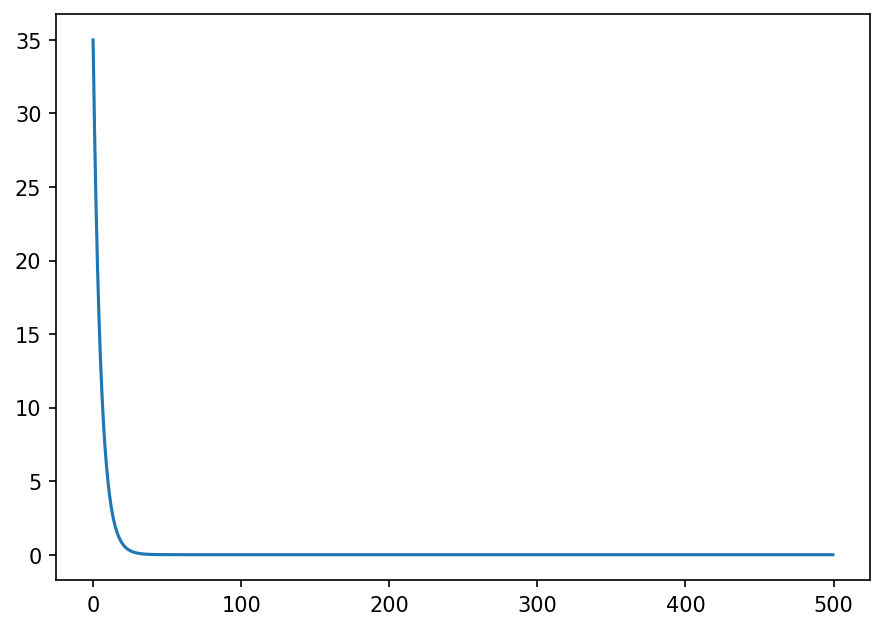

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

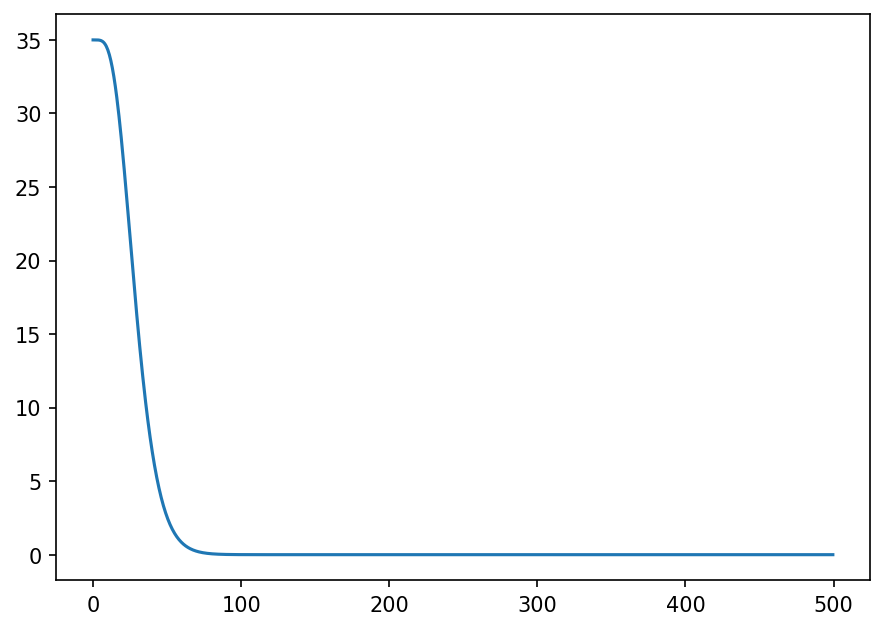

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

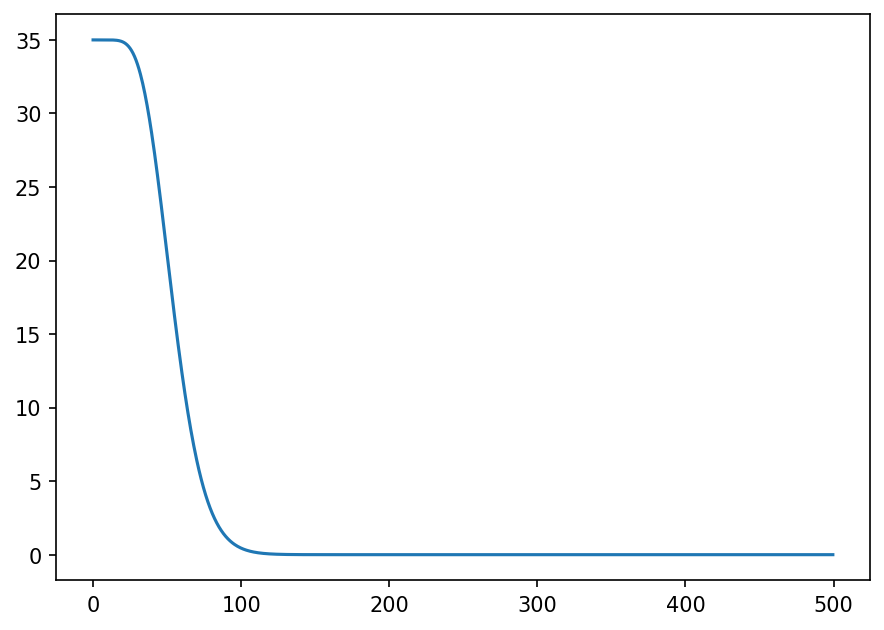

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

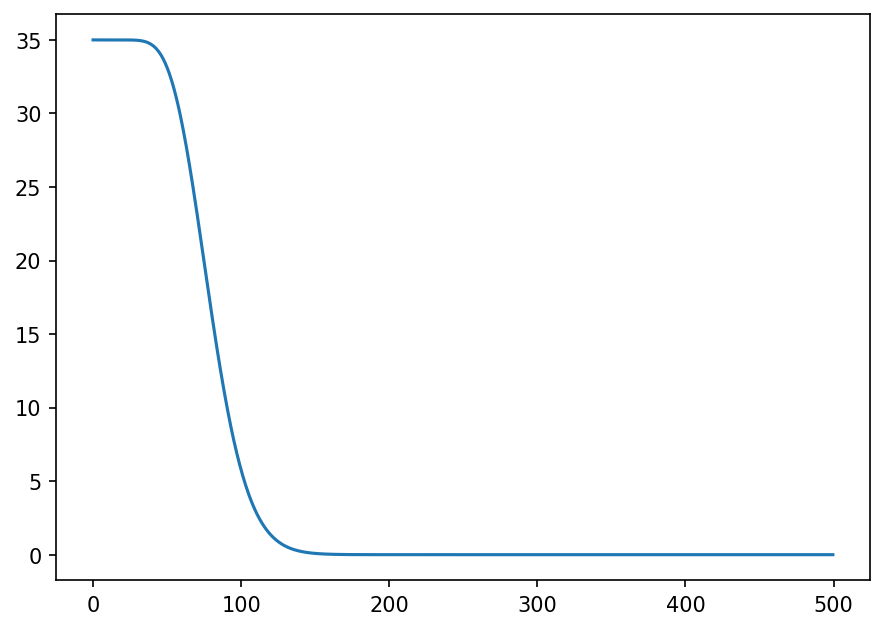

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

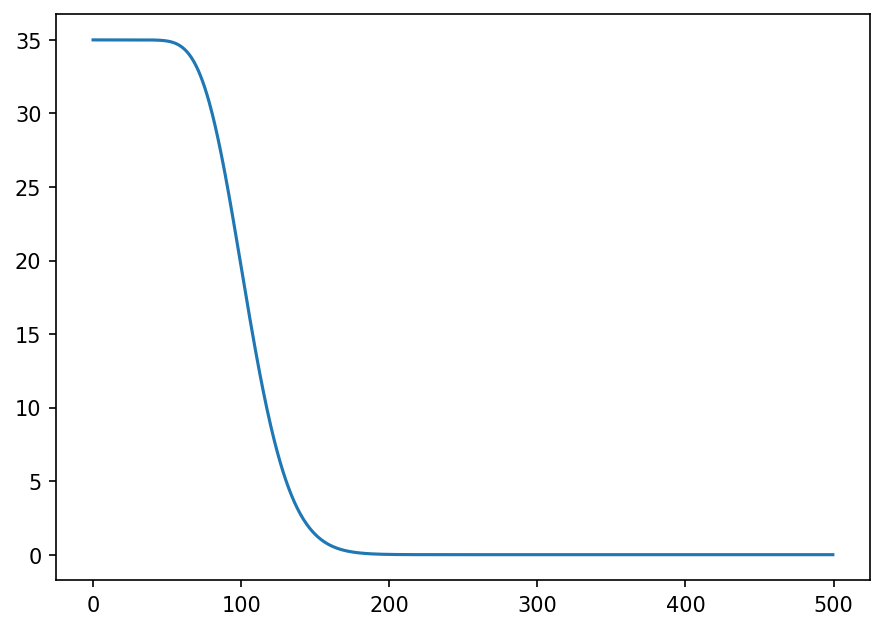

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

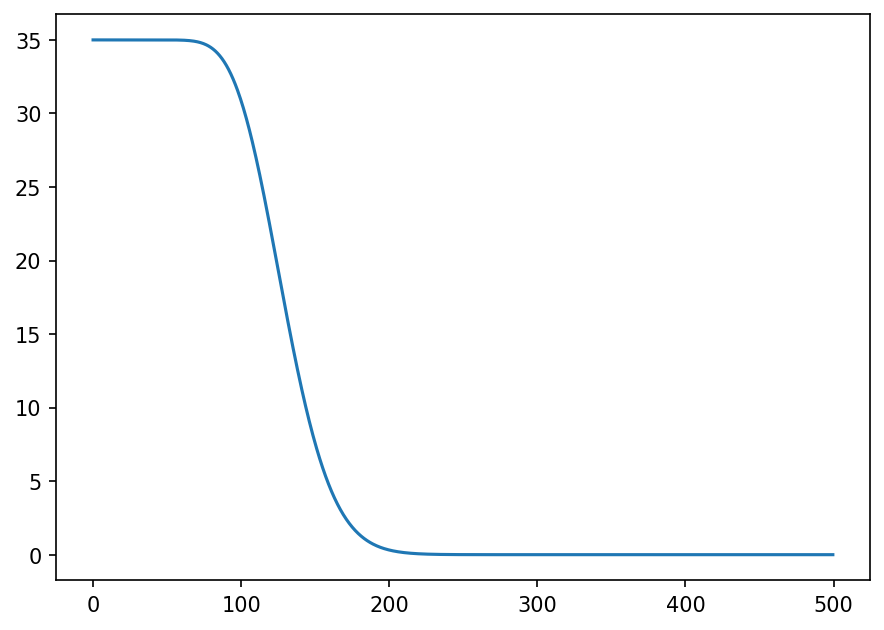

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

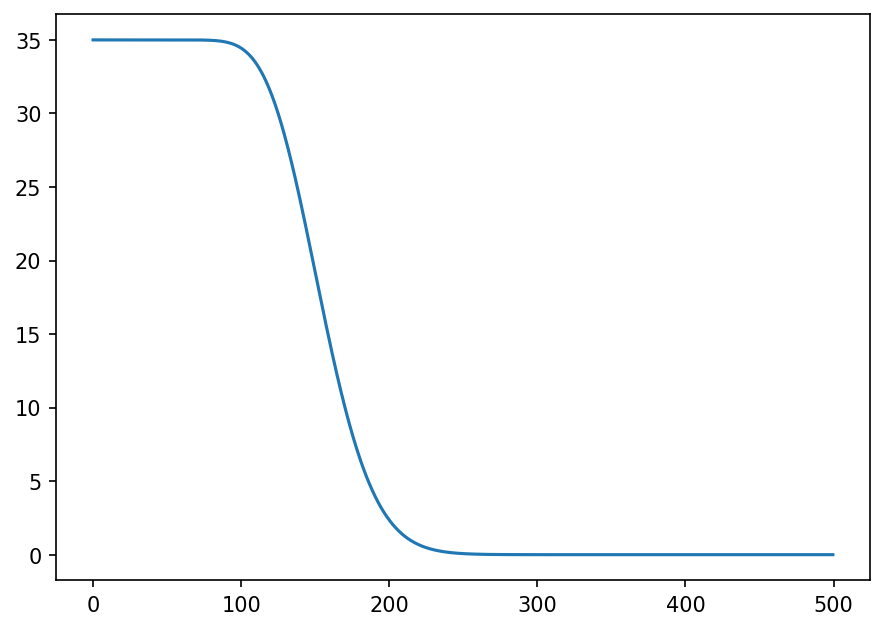

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

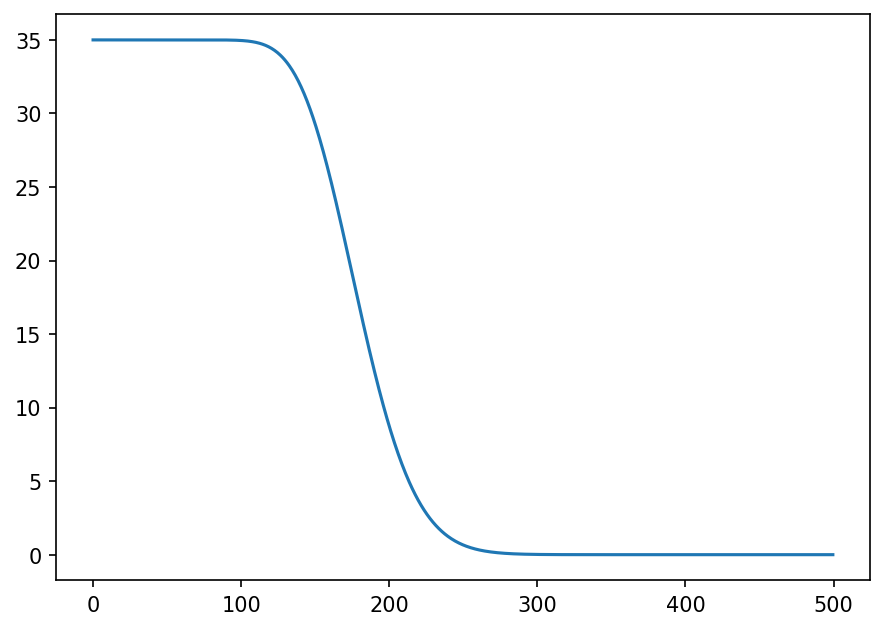

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

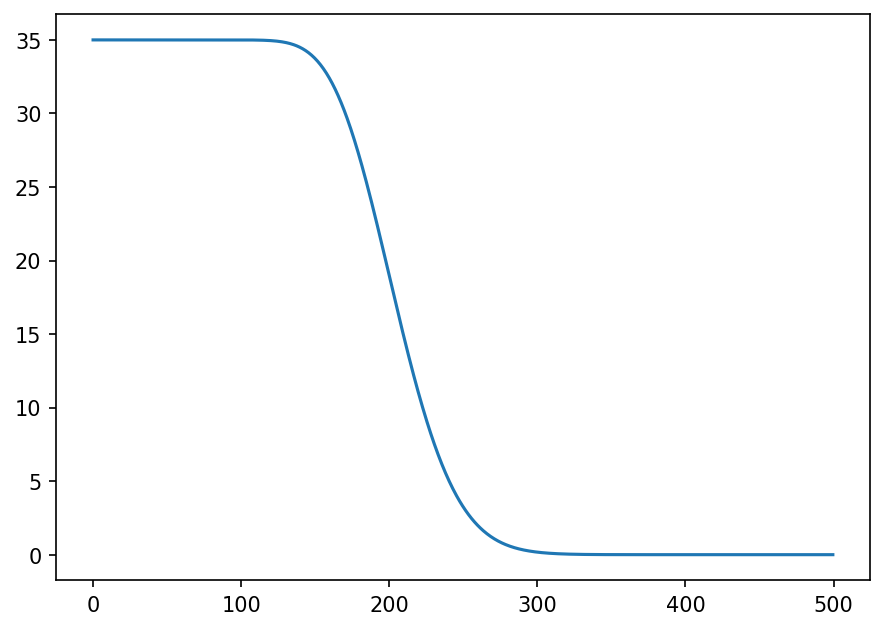

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

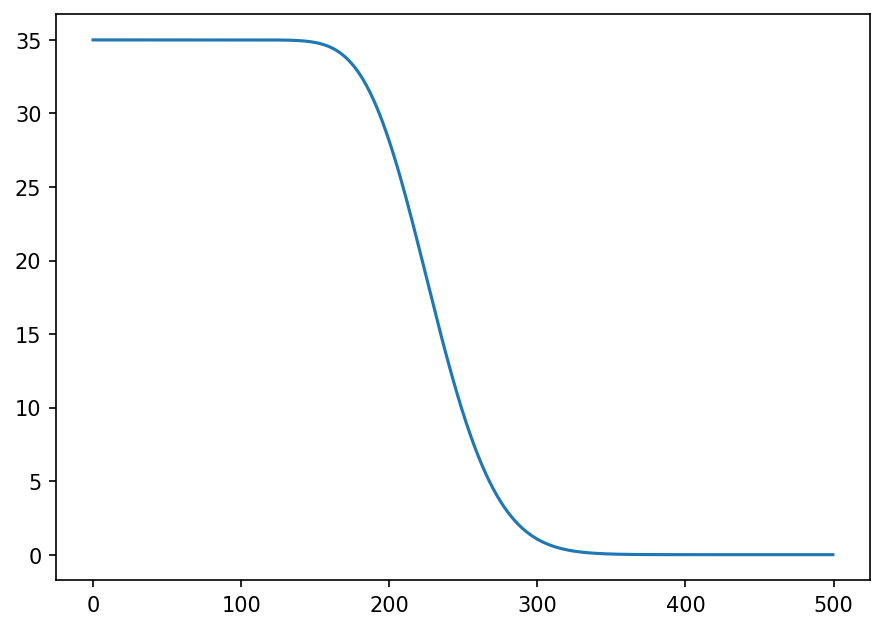

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

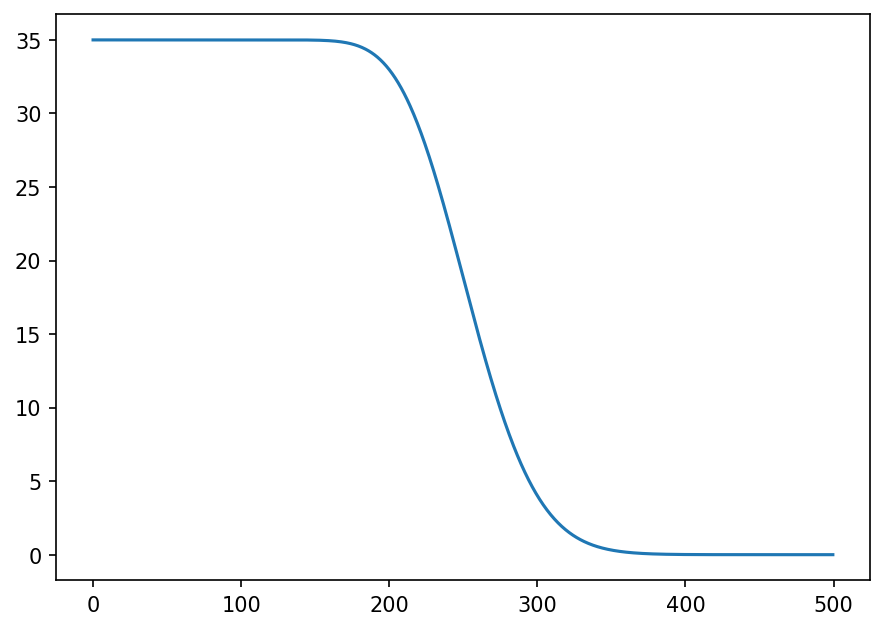

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

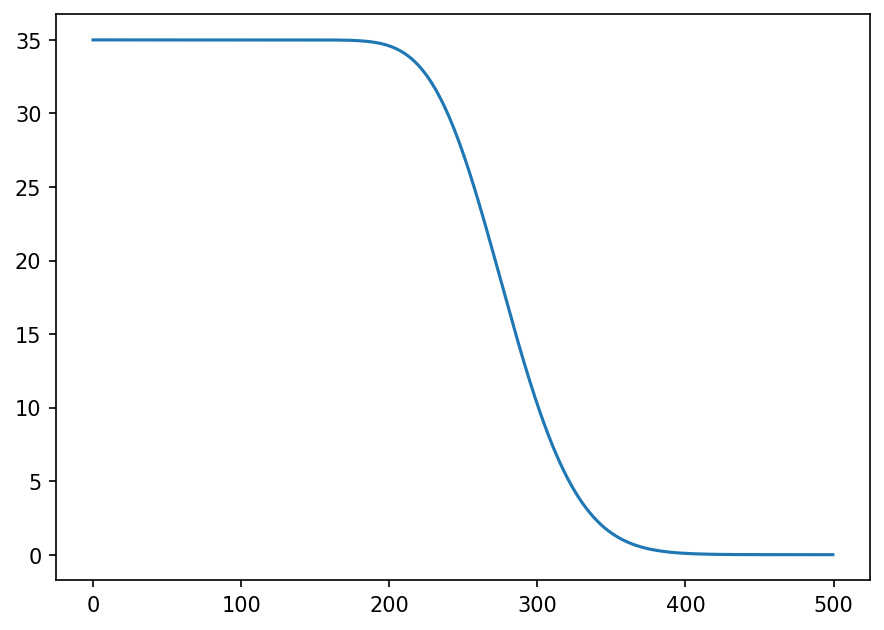

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

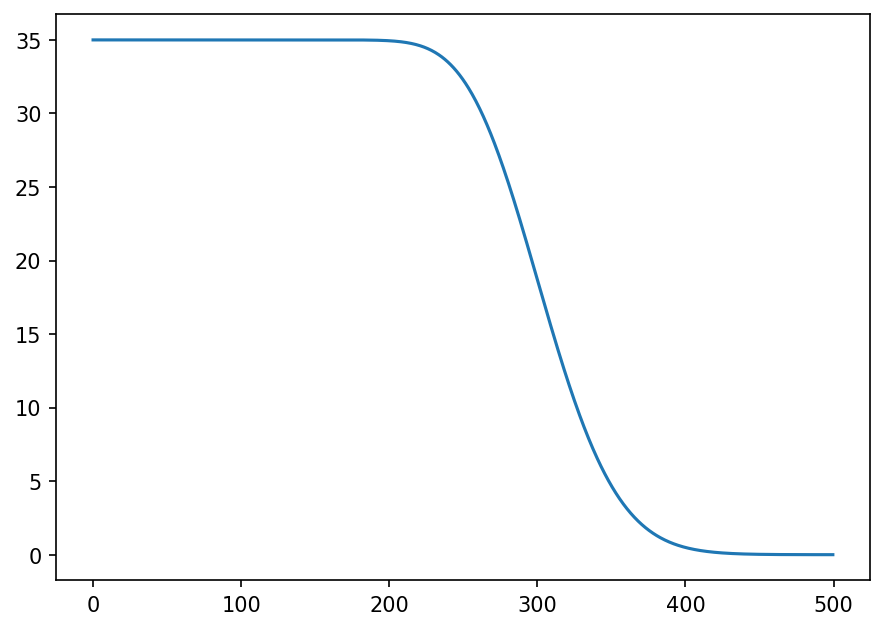

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

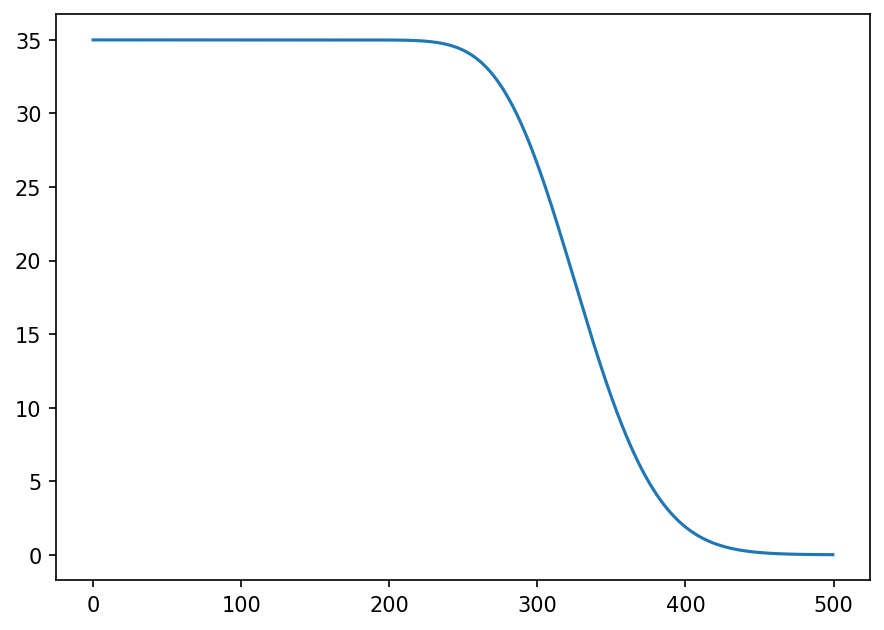

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

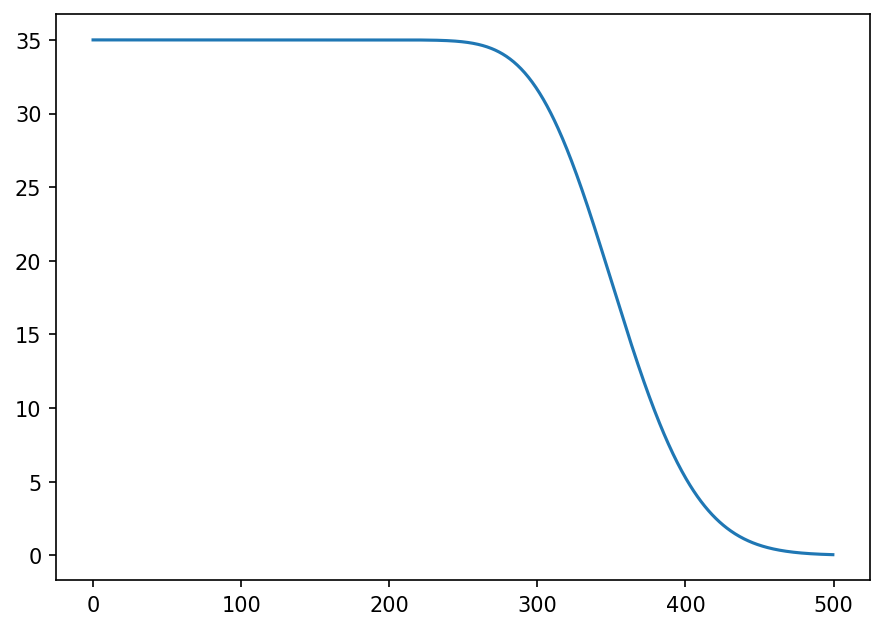

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

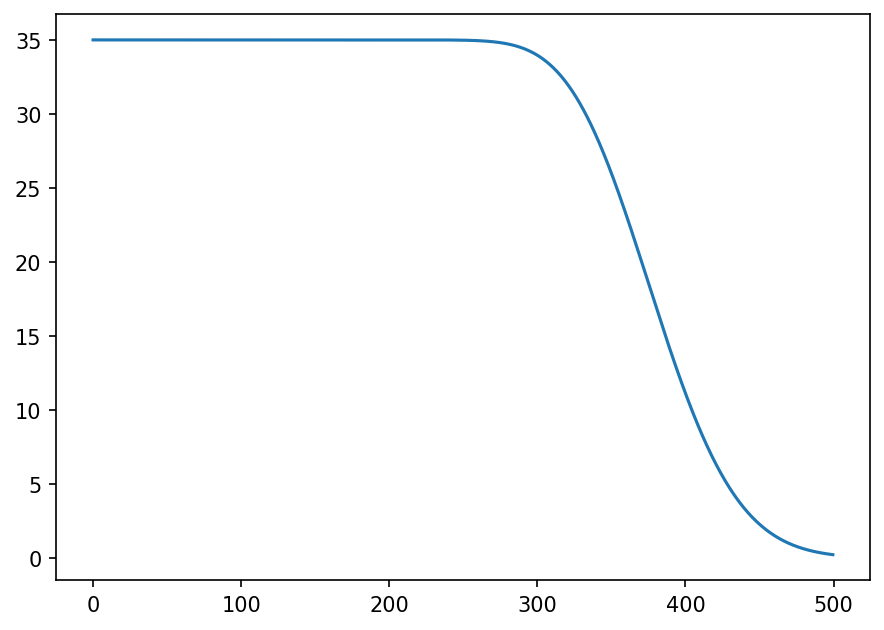

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

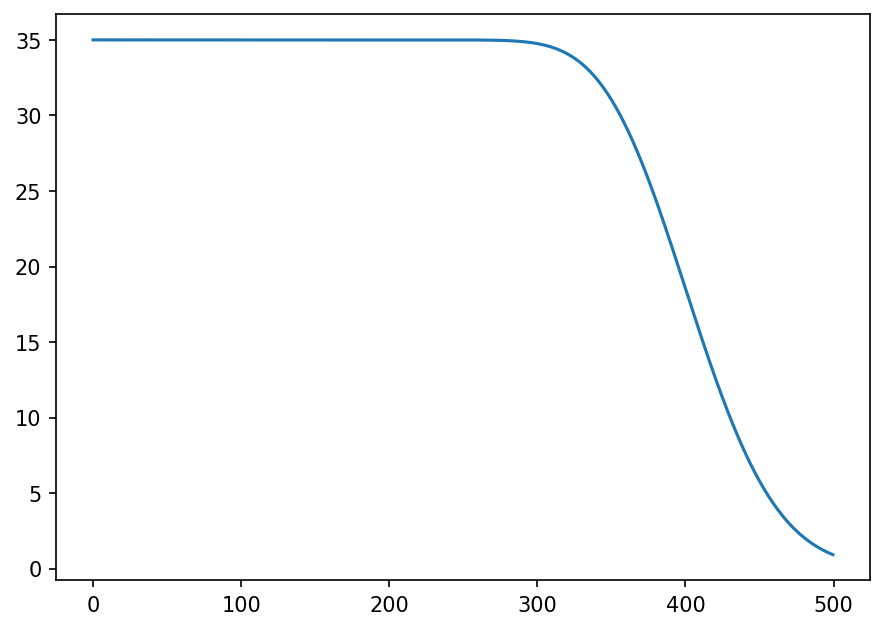

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

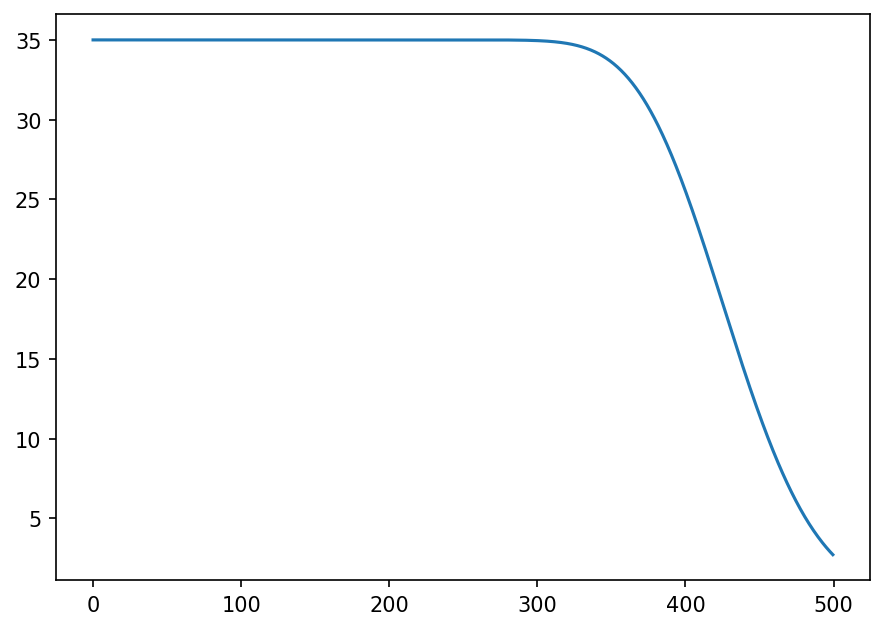

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

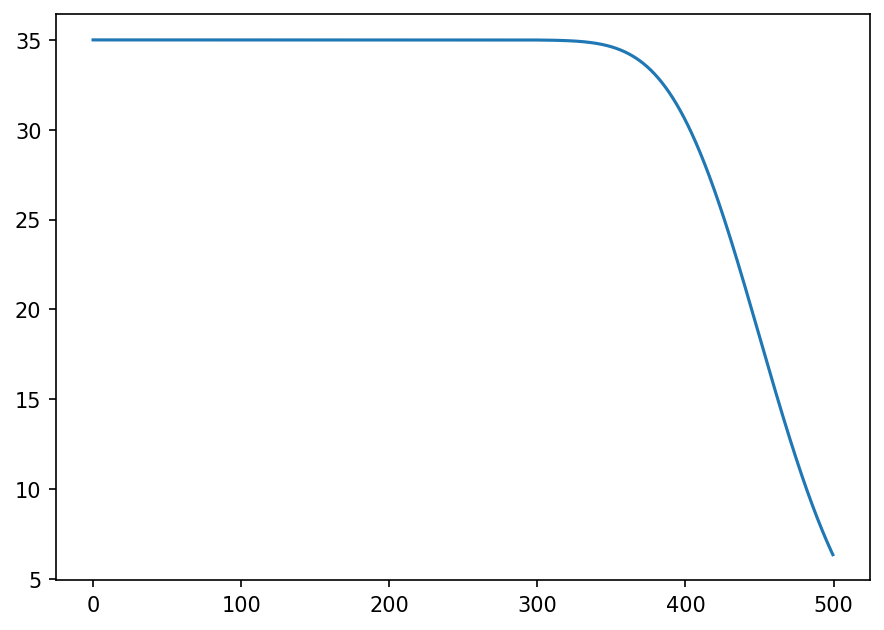

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

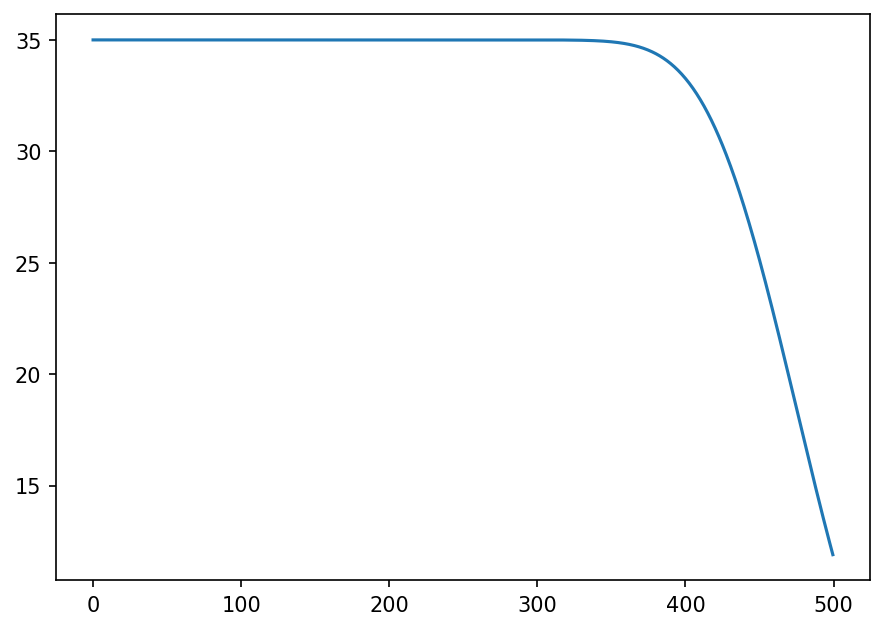

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

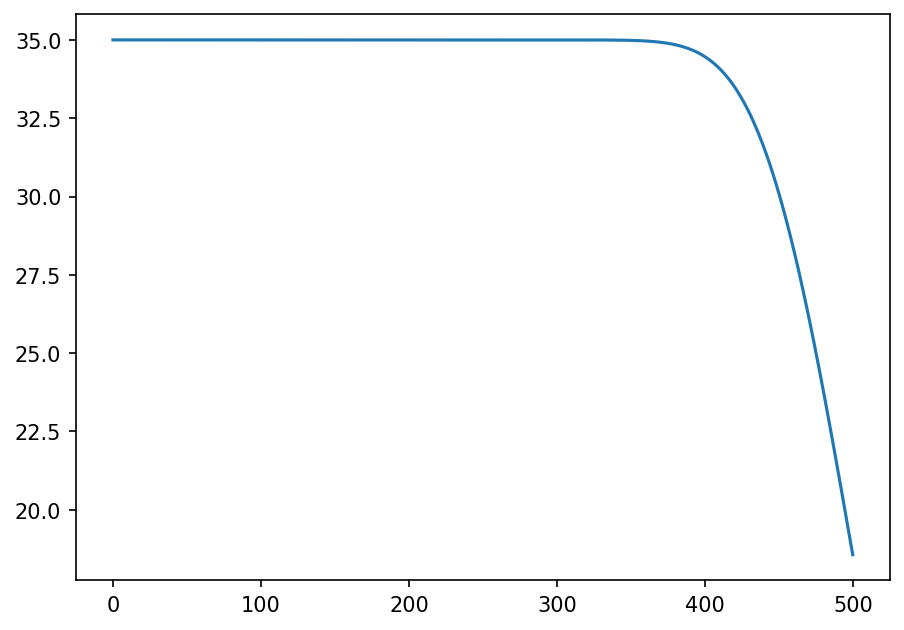

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

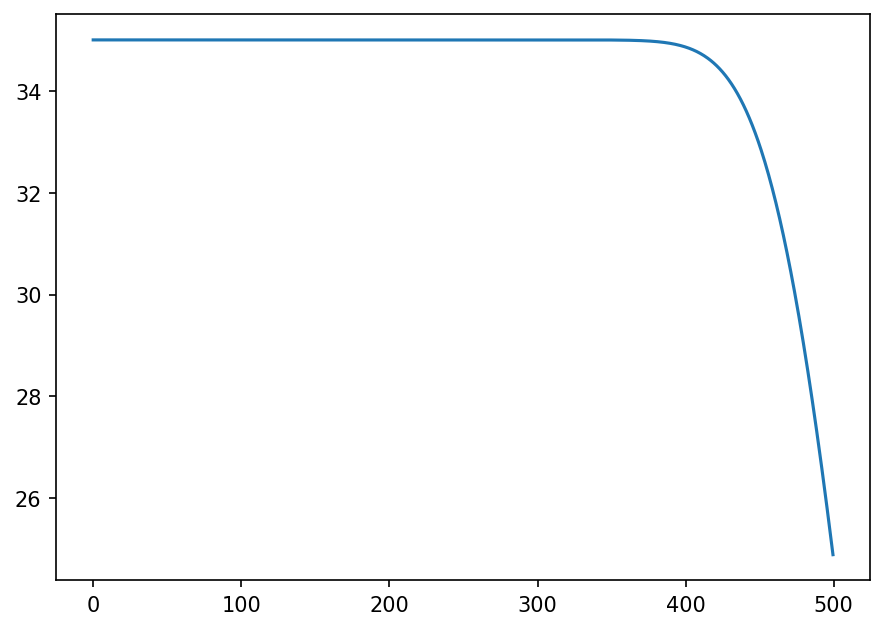

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

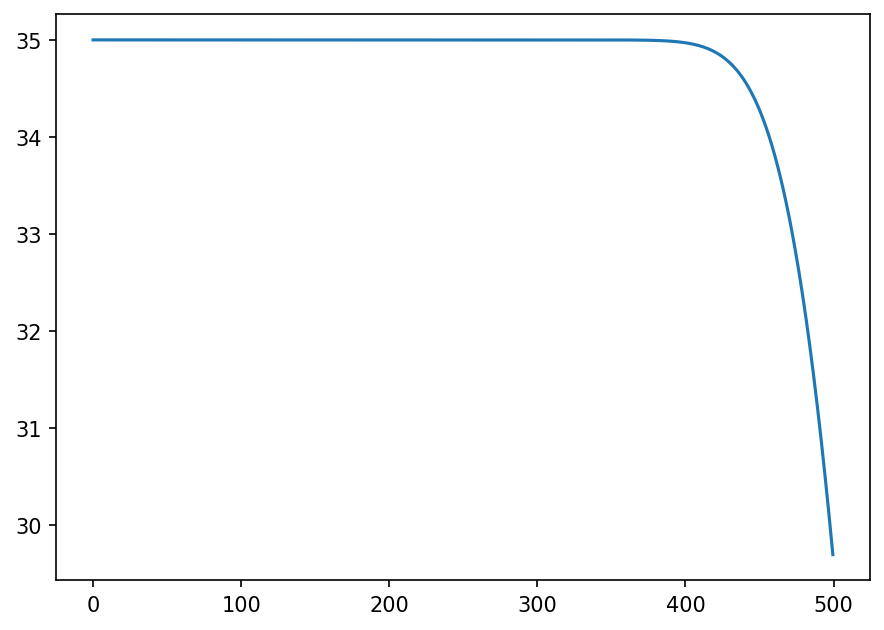

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

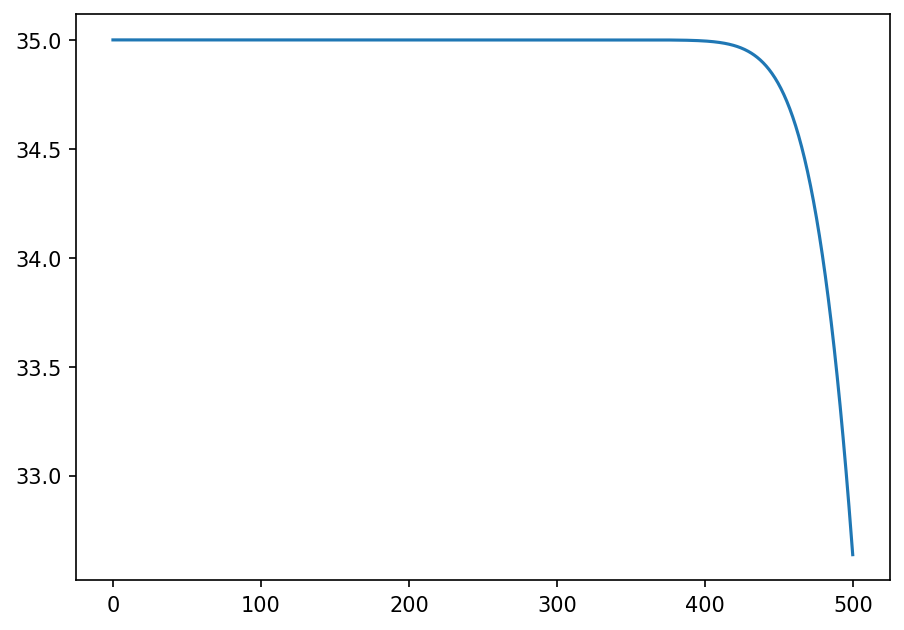

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

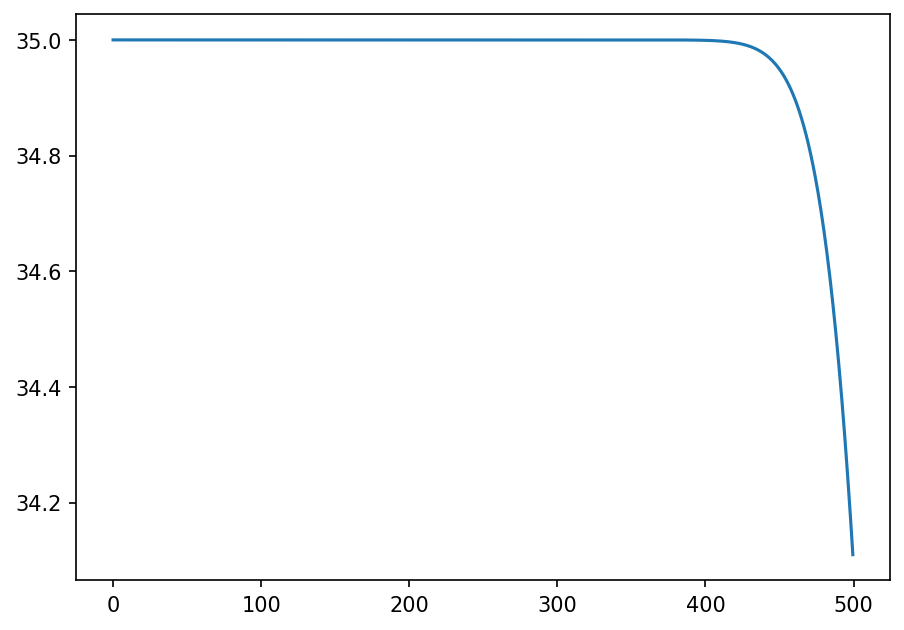

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

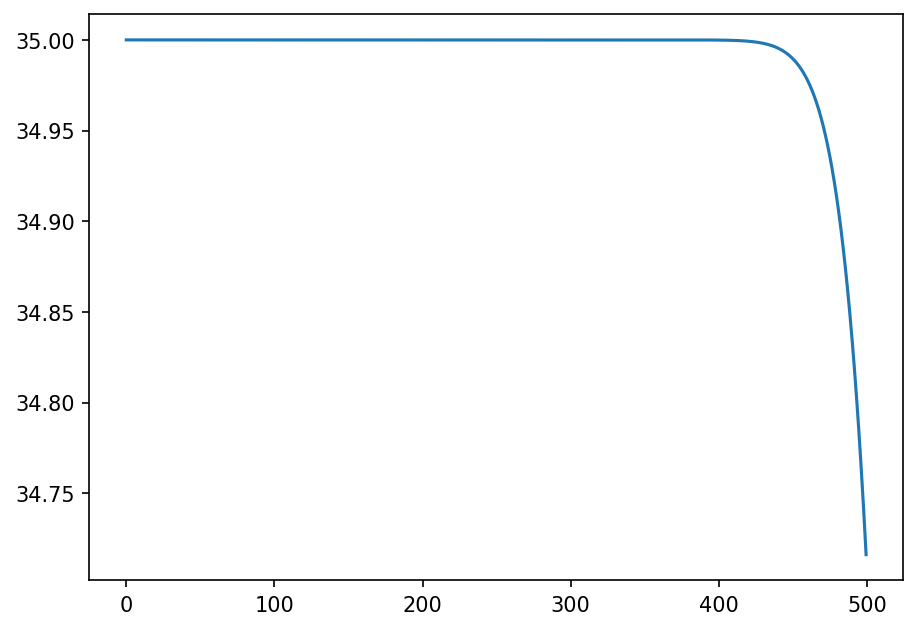

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

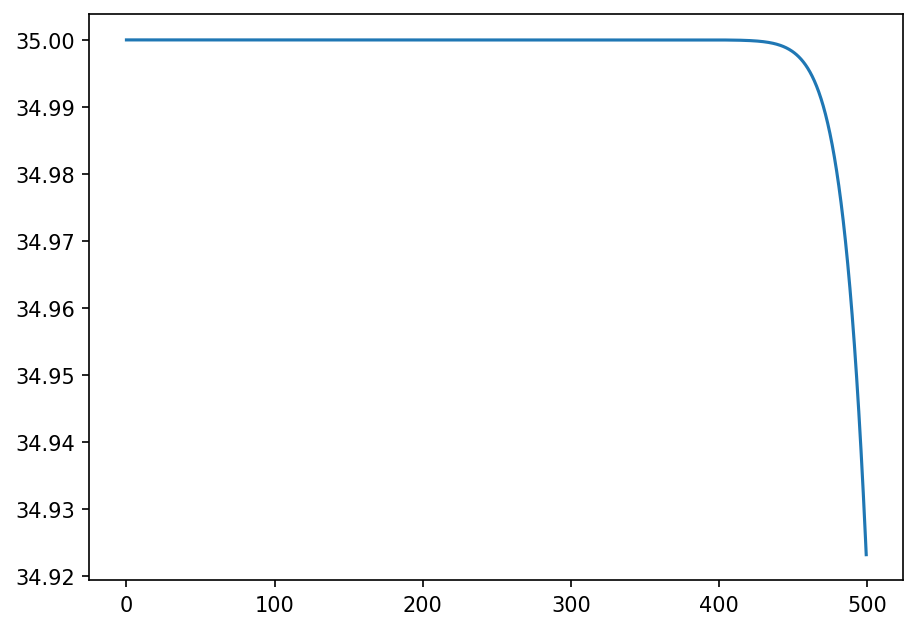

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

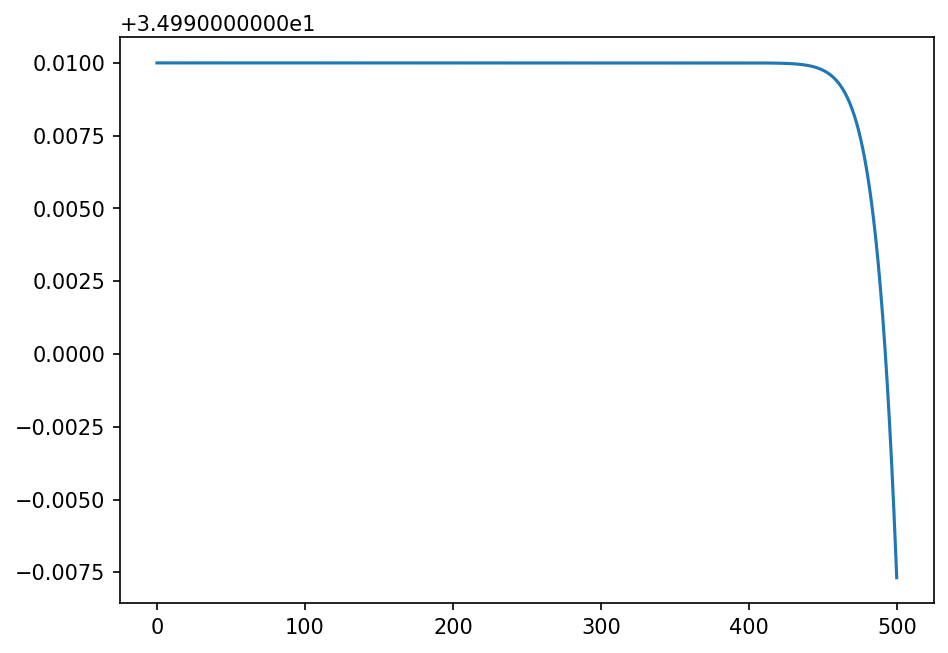

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

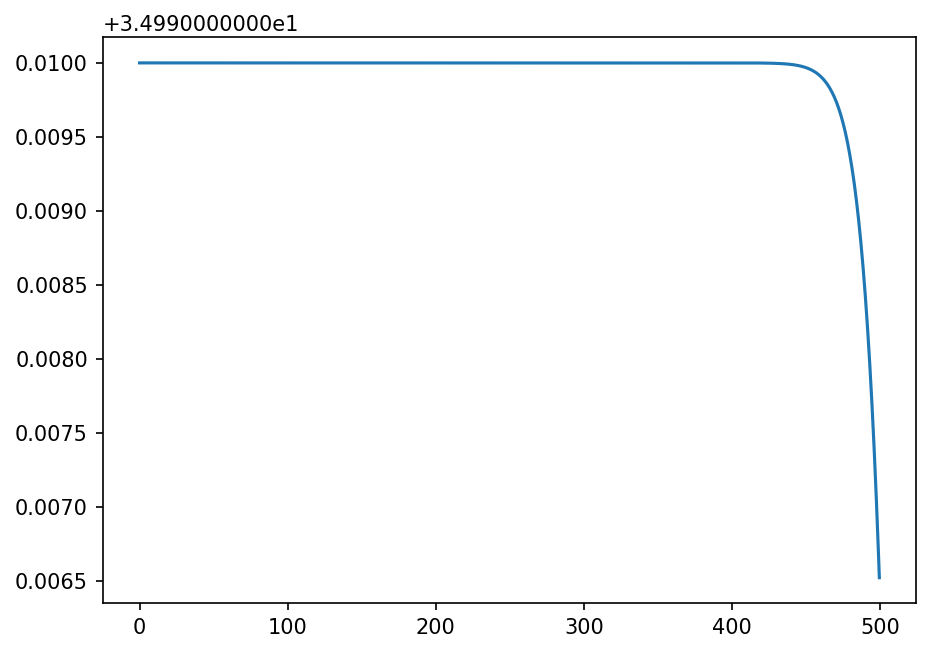

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

In [51]:

for i in range(nt):
    plt.figure(figsize=(7, 5), dpi=150)
    if i%5==0:
        plt.plot(x[0:1000], dummy_answer[i,0:1000])
#   plt.plot(x[0:1000], dummy_answer[5,0:1000])
#   plt.plot(x[0:1000], dummy_answer[10,0:1000])
# # dummy_answer
# for i in range (1,nt):
#     if temp_resposta[i] != 0:
#         plt.plot(x, dummy_answer[i,:])
        